In [3]:
# Comparison among PCA, EFA, and Autoencoder on MSE and EVR
import os

seed = 52
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

print(">>> Global env + basic seeds set, seed =", seed)
import random
import numpy as np
import torch
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

%load_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
import torch
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from model_code import AE, set_deterministic, _total_evr_from_recon
from validators import build_10_items_validators, build_validators_baseline
from utils import get_cbcl_details

from interpretability import CCA_Interpreter

>>> Global env + basic seeds set, seed = 52
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
code_dir = Path.cwd()
data_path = code_dir.parent / 'data'
data_file = data_path / 'cbcl_data_remove_low_frequency.csv'
if not data_file.exists():
    raise FileNotFoundError(f'Could not find {data_file}')

qns = pd.read_csv(data_file, encoding='utf-8')
X = qns.iloc[:, 1:].values


X_train_raw, X_temp = train_test_split(X, test_size=0.2, random_state=seed)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5, random_state=seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_factors = 5

items = [get_cbcl_details(col) for col in qns.iloc[:, 1:].columns]
items = np.array(items)

In [7]:
set_deterministic(seed)

autoencoder = AE(
    X_train,
    X_val,
    encoding_dim=n_factors,
    h1=192,
    h2=64,
    seed=seed,
    lr=0.003,
    lambda_decorr=0.005,
    weight_decay=8e-05,
)
autoencoder.train(show_plot=False)

latent_factors, _, _, evr_test, reconstructed, _ = autoencoder.evaluate_on_data(X_test)
print(f"Evaluating on test set: EVR test = {evr_test:.4f}")

latent_factors, _, _, evr_total, reconstructed, _ = autoencoder.evaluate_on_data(X_scaled)
mse_ae = float(np.mean((X_scaled - reconstructed) ** 2))

print(f'AE -> MSE={mse_ae:.6f}, Total EVR={evr_total:.4f}')


[Seed fixed] random/numpy/torch all set to 52
Using device: cuda
Early stopping at epoch 100
Evaluating on test set: EVR test = 0.3718
AE -> MSE=0.579299, Total EVR=0.4208


In [8]:
latent_factors, rec_errors, explained_variance_ratios, explained_variance_ratio_total, reconstructed, r2 = autoencoder.evaluate_on_data(X_scaled)
print(explained_variance_ratio_total, rec_errors.mean(), r2)
results = CCA_Interpreter.run_cca_interpret(
    latent_factors, X_scaled,
    n_components=5,
    item_names_X=items, 
    impute=True,
    standardize=True,
    random_state=seed,
    n_perm=0,          # 想做置换检验就设为比如 1000
)

0.42082295494672806 0.5792986824200452 0.42070131757995466


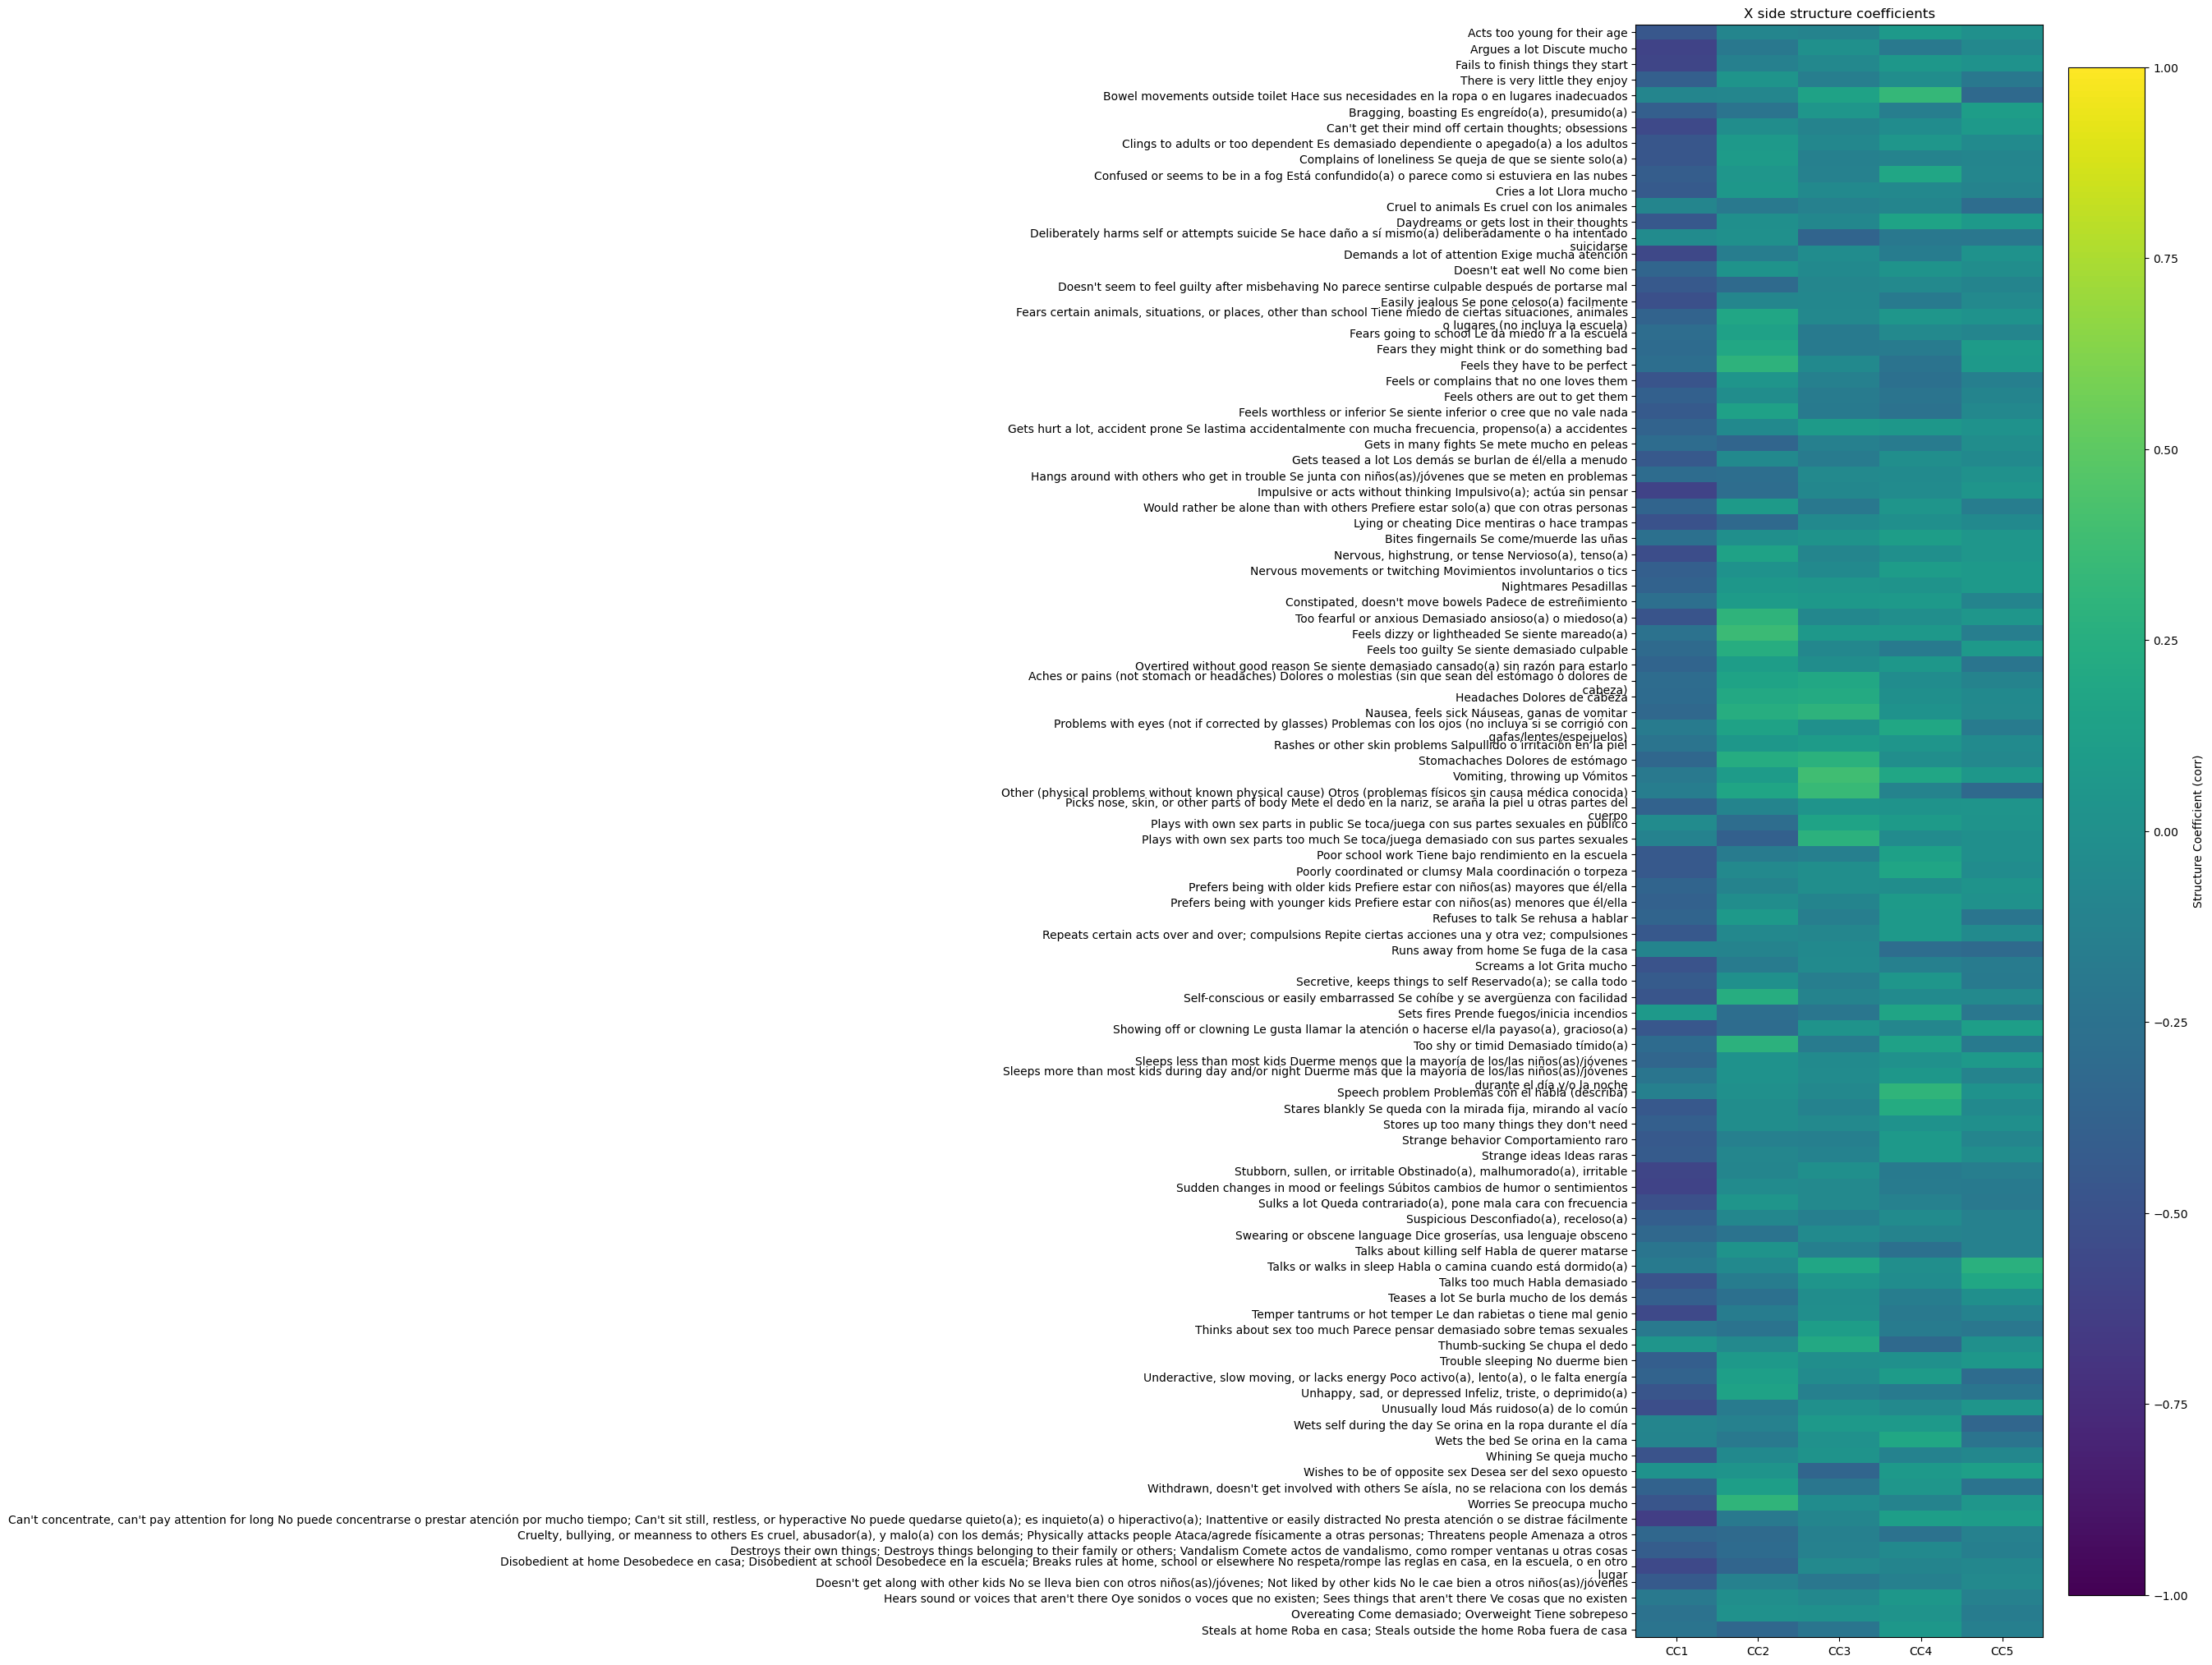

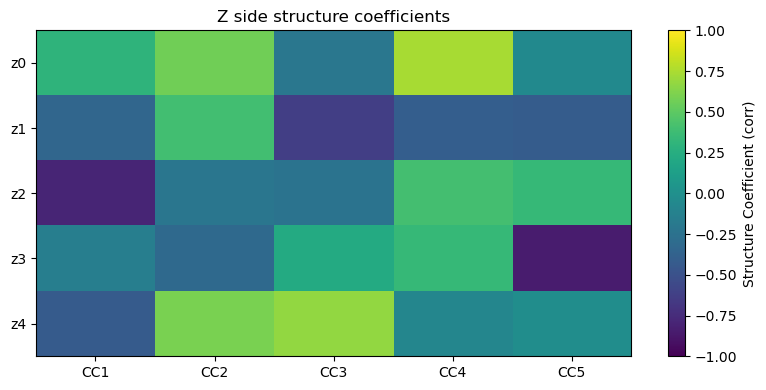

In [9]:
# 使用示例：
CCA_Interpreter.plot_loadings_heatmap(results["X_loadings"], "X side structure coefficients")
CCA_Interpreter.plot_loadings_heatmap(results["Z_loadings"], "Z side structure coefficients")

In [10]:
# 使用：
X_loadings_df = results["X_loadings"]
top_items_dict, top_items_table = CCA_Interpreter.get_top_items_per_cc(X_loadings_df, top_k=10)
print(top_items_dict["CC1"])  # 查看CC1的Top10条目及载荷（含正负）
# top_items_table.to_excel("CCA_top10_items_per_CC.xlsx")

Can't concentrate, can't pay attention for long No puede concentrarse o prestar atención por mucho tiempo; Can't sit still, restless, or hyperactive No puede quedarse quieto(a); es inquieto(a) o hiperactivo(a); Inattentive or easily distracted No presta atención o se distrae fácilmente   -0.630470
Argues a lot Discute mucho                                                                                                                                                                                                                                                                       -0.601359
Impulsive or acts without thinking Impulsivo(a); actúa sin pensar                                                                                                                                                                                                                                -0.600987
Sudden changes in mood or feelings Súbitos cambios de humor o sentimientos                             

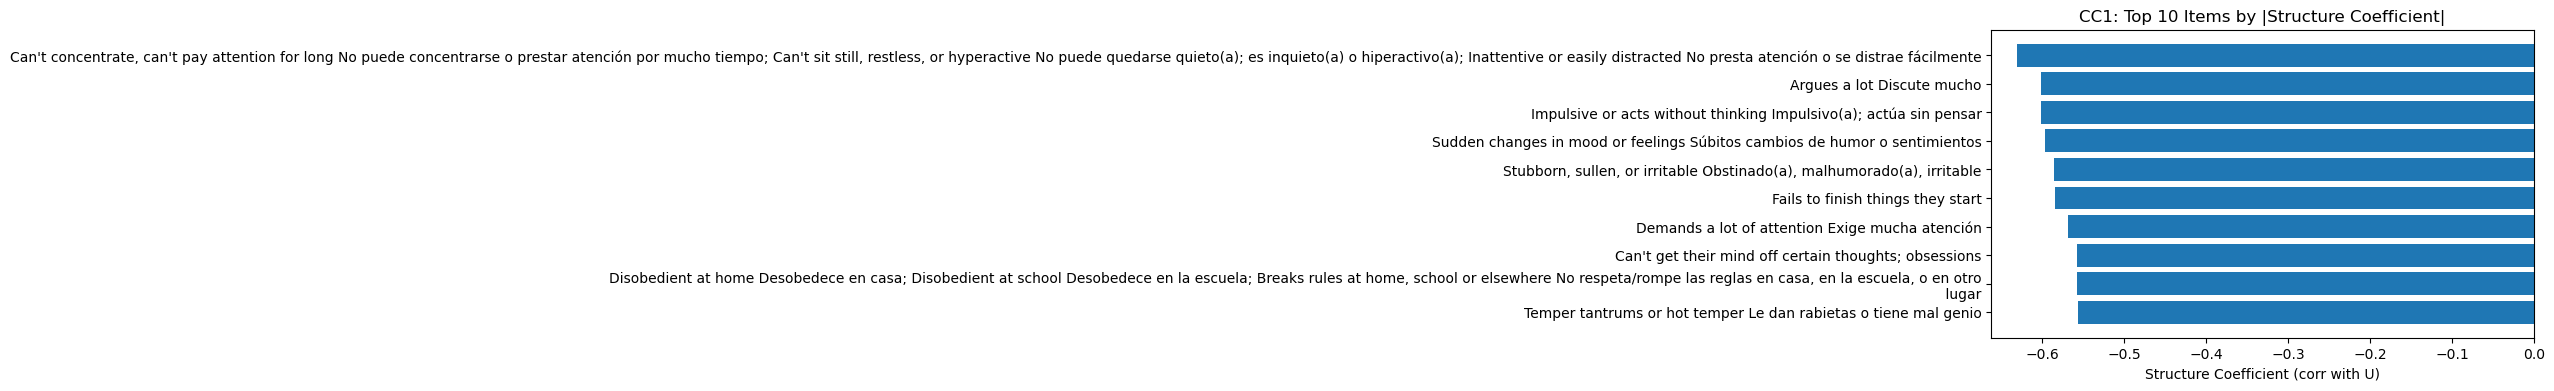

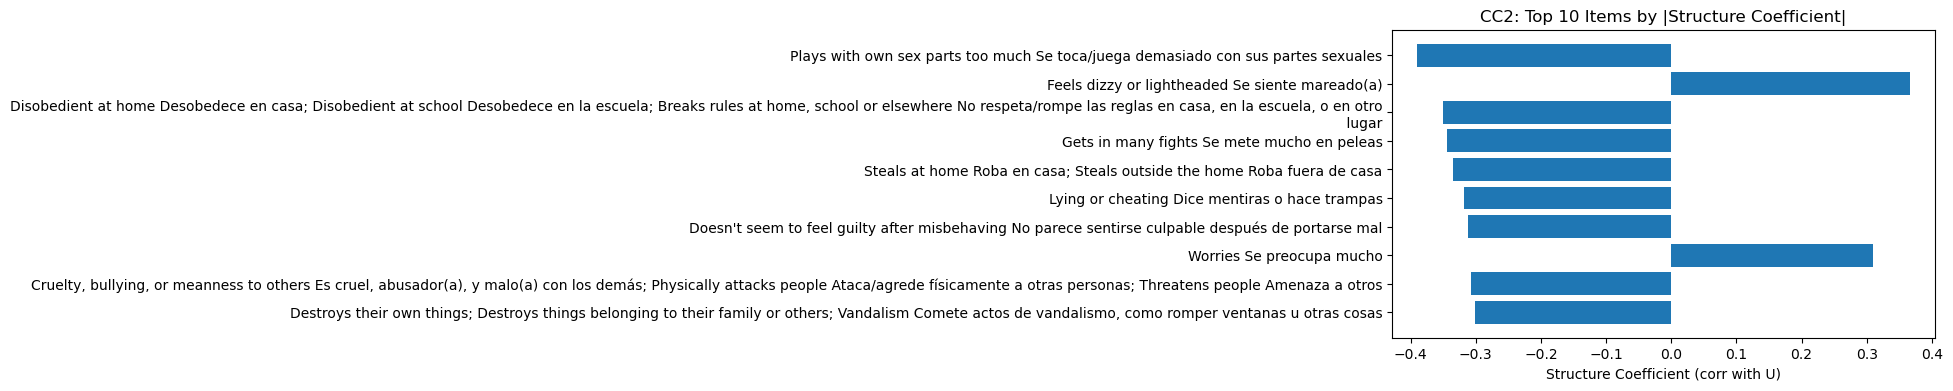

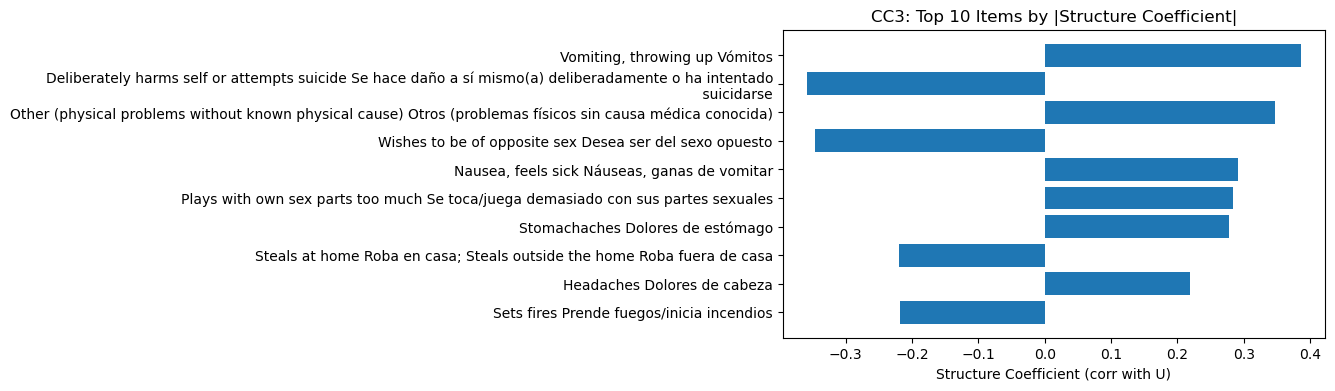

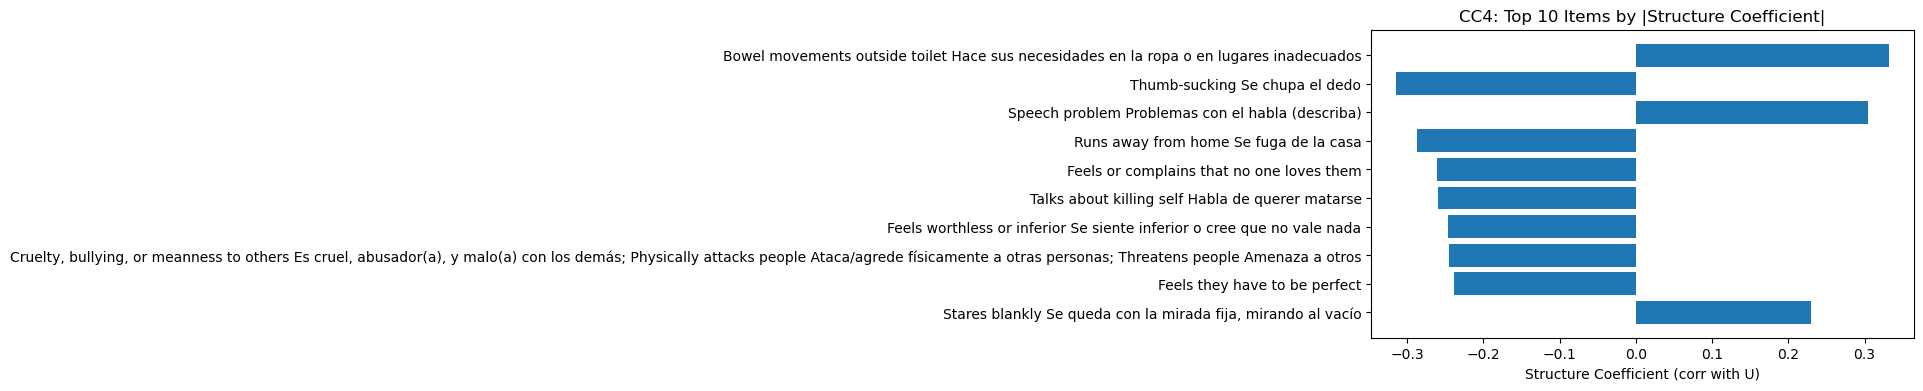

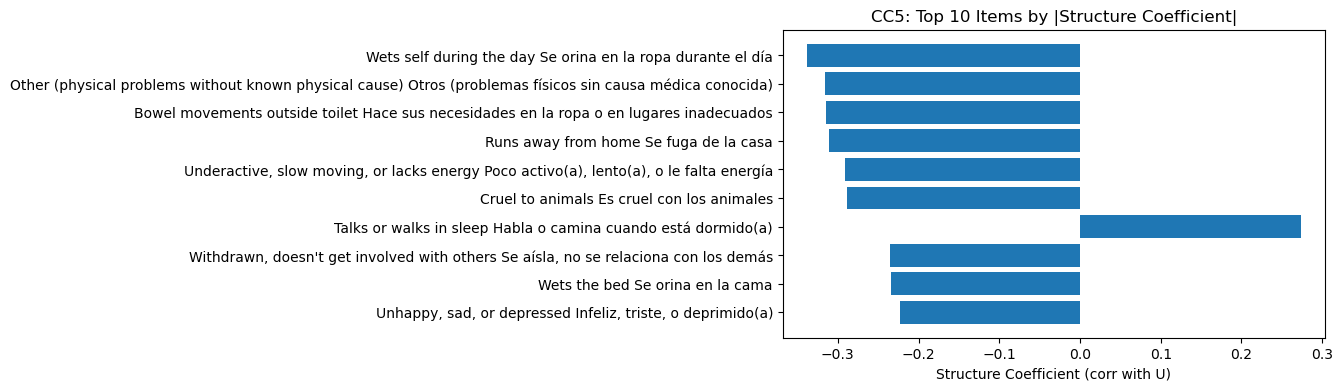

In [11]:
CCA_Interpreter.plot_top_items_per_cc(top_items_dict)
